In [11]:
using Turing, Distributions, DualNumbers, Gadfly, ForwardDiff

# Helper function for the single neuron bnn
function singley(x, w0, w1, w2)
  return 1 / (1 + exp(-(w0 + w1 * x[1] + w2 * x[2])))
end

# Training data
xs = Array[[1, 2], [2, 1], [-2, -1], [-1.5, -2.5]]
ts = [1, 1, 0, 0]

# Define the model
α = 0.25          # regularizatin term
σ = sqrt(1 / α)   # variance of the Gaussian prior
@model singlebnn begin
  @assume w0 ~ Normal(0, σ)
  @assume w1 ~ Normal(0, σ)
  @assume w2 ~ Normal(0, σ)
  for i = 1:4
    y = singley(xs[i], w0, w1, w2)
    @observe ts[i] ~ Bernoulli(y)
  end
  @predict w0 w1 w2
end

# Sample the model
chain = sample(singlebnn, PG(100, 1000))
# chain = sample(singlebnn, HMC(3000, 0.1, 2))


# Helper function for predicting
function singlepredict(x, chain)
  return mean([singley(x, d[:w0], d[:w1], d[:w2]) for d in chain[:samples]])
end

# Compute predctions
y = Float64[singlepredict(xs[i], chain) for i = 1:4]

# Gradient descend
function G(args::Vector)
  w0, w1, w2 = args[1], args[2], args[3]
  error = 0
  for i = 1:4
    y = singley(xs[i], w0, w1, w2)
    error -= ts[i] * log2(y) + (1 - ts[i]) * log(1 - y)
  end
  return error + α * 0.5 * (w0^2 + w1^2 + w2^2)
end

∇G = x -> ForwardDiff.gradient(G, x)

w0g, w1g, w2g = randn(), randn(), randn()

println("Initial loss: ", G([w0g, w1g, w2g]))

iteration_num = 3000
chaing = Array{Dict{Symbol, Any}}(iteration_num)
l_rate = 0.1
for i = 1:iteration_num
  dw = ∇G([w0g, w1g, w2g])
  w0g -= l_rate * dw[1]
  w1g -= l_rate * dw[2]
  w2g -= l_rate * dw[3]
  chaing[i] = Dict{Symbol, Any}(:w0=>w0g, :w1=>w1g, :w2=>w2g)
end

println("Final loss: ", G([w0g, w1g, w2g]))

yg = Float64[singley(xs[i], w0g, w1g, w2g) for i = 1:4]

# Plot predictions
singledata_layer_1 = layer(x=Float64[1, 2], y=Float64[2, 1], Geom.point, Theme(default_color=colorant"red"))
singledata_layer_2 = layer(x=Float64[-1, -2], y=Float64[-2, -1], Geom.point, Theme(default_color=colorant"blue"))
singlepredictions_layer = layer(z=(x,y) -> singlepredict([x, y], chain), x=linspace(-4,4,25), y=linspace(-4,4,25), Geom.contour)


Initial loss: 11.728874271471918
Final loss: 0.4480827071061692


1-element Array{Gadfly.Layer,1}:
 Gadfly.Layer(nothing,Dict{Symbol,Any}(:y=>linspace(-4.0,4.0,25),:z=>(anonymous function),:x=>linspace(-4.0,4.0,25)),Gadfly.StatisticElement[],Gadfly.Geom.LineGeometry(Gadfly.Stat.ContourStatistic(15,150),true,2,symbol("")),nothing,0)

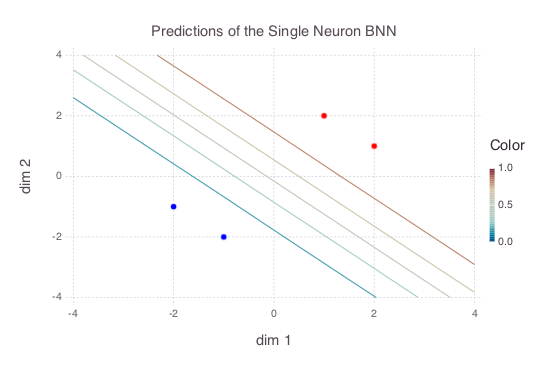

In [12]:
gdpredictions_layer = layer(z=(x,y) -> singley([x, y], w0g, w1g, w2g), x=linspace(-4,4,25), y=linspace(-4,4,25), Geom.contour(levels=5))
singlepredictions_plot1 = plot(singledata_layer_1, singledata_layer_2, gdpredictions_layer, Guide.xlabel("dim 1"), Guide.ylabel("dim 2"),Guide.title("Predictions of the Single Neuron BNN"), Coord.cartesian(xmin=-4, xmax=4, ymin=-4, ymax=4))

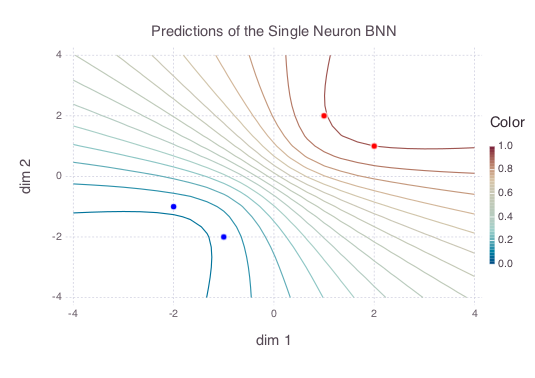

In [13]:
singlepredictions_plot2 = plot(singledata_layer_1, singledata_layer_2, singlepredictions_layer, Guide.xlabel("dim 1"), Guide.ylabel("dim 2"),Guide.title("Predictions of the Single Neuron BNN"), Coord.cartesian(xmin=-4, xmax=4, ymin=-4, ymax=4))


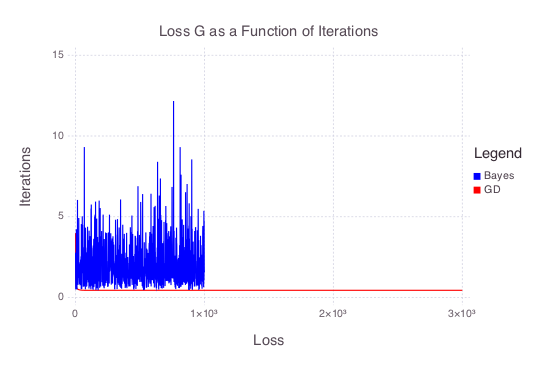

In [14]:
# Loss plot
loss_bayes = Float64[G([d[:w0], d[:w1], d[:w2]]) for d in chain[:samples]]
loss_gard = Float64[G([d[:w0], d[:w1], d[:w2]]) for d in chaing]

mean(loss_bayes)

lossb_layer = layer(x=1:length(loss_bayes), y=loss_bayes, Geom.line, Theme(default_color=colorant"blue"))
lossg_layer = layer(x=1:length(loss_gard), y=loss_gard, Geom.line, Theme(default_color=colorant"red"))
single_loss_plot = plot(lossb_layer, lossg_layer, Guide.xlabel("Loss"), Guide.ylabel("Iterations"), Guide.title("Loss G as a Function of Iterations"), Guide.manual_color_key("Legend", ["Bayes", "GD"], ["blue", "red"]))